✅ Workflow Plan:
* Step 1: Load and explore the dataset.
* Step 2: Preprocessing + add <start> and <end> tokens.
* Step 3: Tokenization (with <OOV> handling).
* Step 4: Padding and sequence preparation.
* Step 5: Model 1 — Seq2Seq encoder-decoder model setup.
* Step 6: Training + loss plots.
* Step 7: Model 2 — Transformer-style seq2seq setup.
* Step 8: Training + loss plots.
* Step 9: Inference testing on unseen data..

## STEP 1: Load & Explore Dataset

---



In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import matplotlib.pyplot as plt

# Path to your dataset (adjust if needed)
file_path = '/content/drive/MyDrive/MT_Data/english-arabic-dataset.txt'

# Load first 10,000 lines
with open(file_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()[:10000]

print(f"Total samples loaded: {len(lines)}")

Total samples loaded: 10000


In [4]:
# Separate English and Arabic sentences
eng_sentences = [str(line[0]) for line in lines]
arb_sentences = [str(line[1]) for line in lines]

for line in lines:
    try:
        eng, arb = line.strip().split('\t')
        eng_sentences.append(eng)
        arb_sentences.append(arb)
    except ValueError:
        continue
# Print 5 samples
for i in range(5):
    print(f"ENGLISH: {eng_sentences[i]}")
    print(f"ARABIC : {arb_sentences[i]}")
    print('---')

ENGLISH: H
ARABIC : i
---
ENGLISH: R
ARABIC : u
---
ENGLISH: H
ARABIC : e
---
ENGLISH: J
ARABIC : u
---
ENGLISH: S
ARABIC : t
---


In [5]:
# Sentence length analysis
eng_lengths = [len(sentence.split()) for sentence in eng_sentences]
arb_lengths = [len(sentence.split()) for sentence in arb_sentences]

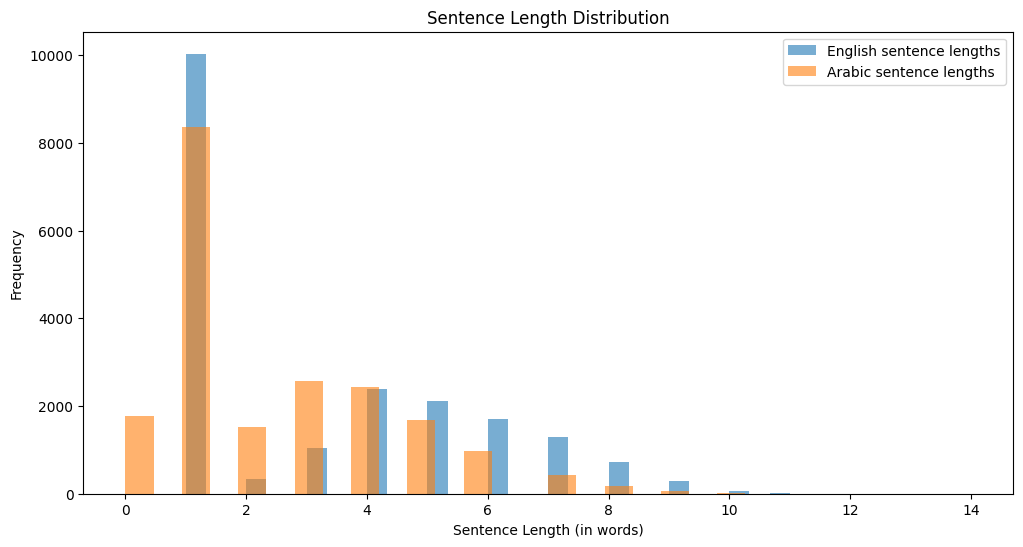

In [6]:
# Plot distributions
plt.figure(figsize=(12,6))
plt.hist(eng_lengths, bins=30, alpha=0.6, label='English sentence lengths')
plt.hist(arb_lengths, bins=30, alpha=0.6, label='Arabic sentence lengths')
plt.title("Sentence Length Distribution")
plt.xlabel("Sentence Length (in words)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [7]:
# Check max lengths
print(f"Max English sentence length: {max(eng_lengths)}")
print(f"Max Arabic sentence length: {max(arb_lengths)}")

Max English sentence length: 11
Max Arabic sentence length: 14


## STEP 2: Preprocessing + Adding <start>, <end> Tokens

---


*   Lowercase
*   Strip whitespace
*   Remove punctuation
*   Remove digits if any
*   Remove double spaces
*   Start and end tokens added only on Arabic sentences.


In [8]:
# Function to clean and add special tokens
import re

def clean_sentence(sentence):
    # Lowercase
    sentence = sentence.lower().strip()
    # Remove punctuation and digits
    sentence = re.sub(r"[^a-zA-Zء-ي\s]", "", sentence)  # keeps Arabic & English letters and spaces only
    # Remove extra spaces
    sentence = re.sub(r'\s+', ' ', sentence).strip()
    return sentence

def preprocess_arabic(sentence):
    sentence = clean_sentence(sentence)
    sentence = f"<start> {sentence} <end>"
    return sentence

def preprocess_english(sentence):
    sentence = clean_sentence(sentence)
    return sentence

# Apply cleaning
eng_sentences_cleaned = [preprocess_english(sent) for sent in eng_sentences]
arb_sentences_cleaned = [preprocess_arabic(sent) for sent in arb_sentences]

# Sanity check
for i in range(5):
    print(f"ENGLISH: {eng_sentences_cleaned[i]}")
    print(f"ARABIC : {arb_sentences_cleaned[i]}")
    print("---")

ENGLISH: h
ARABIC : <start> i <end>
---
ENGLISH: r
ARABIC : <start> u <end>
---
ENGLISH: h
ARABIC : <start> e <end>
---
ENGLISH: j
ARABIC : <start> u <end>
---
ENGLISH: s
ARABIC : <start> t <end>
---


## STEP 3: Tokenization with OOV handling and padding

---


In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# English tokenizer
eng_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token='<OOV>')
eng_tokenizer.fit_on_texts(eng_sentences_cleaned)
eng_tensor = eng_tokenizer.texts_to_sequences(eng_sentences_cleaned)
eng_tensor = tf.keras.preprocessing.sequence.pad_sequences(eng_tensor, padding='post')

# Arabic tokenizer
arb_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token='<OOV>')
arb_tokenizer.fit_on_texts(arb_sentences_cleaned)
arb_tensor = arb_tokenizer.texts_to_sequences(arb_sentences_cleaned)
arb_tensor = tf.keras.preprocessing.sequence.pad_sequences(arb_tensor, padding='post')

# Find max lengths
english_vocab_size = len(eng_tokenizer.word_index) + 1
arabic_vocab_size = len(arb_tokenizer.word_index) + 1
max_eng_len = eng_tensor.shape[1]
max_ar_len = arb_tensor.shape[1]

print(f"English vocab size: {english_vocab_size}")
print(f"Arabic vocab size: {arabic_vocab_size}")

English vocab size: 3601
Arabic vocab size: 8795


note : max length was 14 + 2 = 16

In [12]:
# Pad sequences
#eng_tensor = pad_sequences(eng_tensor, maxlen=max_eng_len, padding='post')
#arb_tensor = pad_sequences(arb_tensor, maxlen=max_ar_len, padding='post')

# Sanity check: print example
for i in range(3):
    print(f"English sequence: {eng_tensor[i]}")
    print(f"Arabic sequence: {arb_tensor[i]}")
    print("---")

print("Tokenization & padding step done bestie!")

English sequence: [10  0  0  0  0  0  0  0  0  0  0]
Arabic sequence: [ 2 25  3  0  0  0  0  0  0  0  0  0  0  0  0  0]
---
English sequence: [361   0   0   0   0   0   0   0   0   0   0]
Arabic sequence: [ 2 58  3  0  0  0  0  0  0  0  0  0  0  0  0  0]
---
English sequence: [10  0  0  0  0  0  0  0  0  0  0]
Arabic sequence: [2 6 3 0 0 0 0 0 0 0 0 0 0 0 0 0]
---
Tokenization & padding step done bestie!


## STEP 4 : Prepare training and validation sets

---


### Data Split - 75% train 25% test/// MADE 90%

In [14]:
from sklearn.model_selection import train_test_split

split_ratio = 0.9
split_index = int(len(eng_tensor) * split_ratio)

english_train, english_val = eng_tensor[:split_index], eng_tensor[split_index:]
arabic_train, arabic_val = arb_tensor[:split_index], arb_tensor[split_index:]

print(f"English train shape: {english_train.shape}")
print(f"English val shape: {english_val.shape}")
print(f"Arabic train shape: {arabic_train.shape}")
print(f"Arabic val shape: {arabic_val.shape}")


English train shape: (18000, 11)
English val shape: (2000, 11)
Arabic train shape: (18000, 16)
Arabic val shape: (2000, 16)


## Step 5: LSTM Seq2Seq Model


---



### Seq2Seq with RNN-based encoder-decoder

* Static LR = 0.0005

* Add ReduceLROnPlateau with factor=0.5, patience=3

* Add EarlyStopping with patience=5

* Train for max 50 epochs -- early stop/ just an upper limit  

* Batch size 64


2ND APPROACH
   
*   Add Dropout layers (with rates between 0.3–0.5)

* Add L2 weight regularization

* Use LearningRateScheduler to fine-tune

* Reduce batch size from 64 to something like 32

3RD AOOROACH

* Recurrent dropout & L2 regularization
* Reduced LSTM units
* Gradient clipping in the optimizer
* Learning rate scheduler callback


4RTH APROACH
* Try reducing LSTM AGAIN

* Stronger L2 regularization

* Dropout after embeddings

* Gaussian noise for extra regularization

* Early stopping with more patience

In [15]:
embedding_dim = 64
lstm_units = 128

In [16]:
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Dropout, GaussianNoise, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau

In [17]:
def scheduler(epoch, lr):
  if epoch < 8:
    return lr
  else:
    return lr * tf.math.exp(-0.1).numpy() # Convert Tensor to float using .numpy()
lr_scheduler = LearningRateScheduler(scheduler)

# Custom loss function that ignores padding (zeros)
def masked_sparse_categorical_crossentropy(y_true, y_pred):
    mask = tf.cast(tf.not_equal(y_true, 0), dtype=tf.float32)
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    loss *= mask
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

In [18]:
# Encoder

encoder_inputs = tf.keras.Input(shape=(None,))
encoder_embed = tf.keras.layers.Embedding(english_vocab_size, embedding_dim)(encoder_inputs)
encoder_lstm = tf.keras.layers.LSTM(lstm_units, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embed)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = tf.keras.Input(shape=(None,))
decoder_embed = tf.keras.layers.Embedding(arabic_vocab_size, embedding_dim)(decoder_inputs)
decoder_lstm = tf.keras.layers.LSTM(lstm_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embed, initial_state=encoder_states)
decoder_dense = tf.keras.layers.Dense(arabic_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)


In [19]:
# Model
lstm_model = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
lstm_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

In [20]:
# Prepare data for decoder
train_arb_in = arabic_train[:, :-1]
train_ar_out = arabic_train[:, 1:]
val_ar_in = arabic_val[:, :-1]
val_ar_out = arabic_val[:, 1:]

In [22]:
print(f"English train shape: {english_train.shape}")
print(f"English val shape: {english_val.shape}")
print(f"Arabic train input shape: {train_arb_in.shape}")
print(f"Arabic train output shape: {train_ar_out.shape}")

English train shape: (18000, 11)
English val shape: (2000, 11)
Arabic train input shape: (18000, 15)
Arabic train output shape: (18000, 15)


## STEP 6: Train LSTM Model

---



In [23]:
history = lstm_model.fit([english_train, train_arb_in], train_ar_out,
                         validation_data=([english_val, val_ar_in], val_ar_out),
                         batch_size=64, epochs=20, callbacks=[early_stop, reduce_lr])


Epoch 1/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - accuracy: 0.7907 - loss: 3.3228 - val_accuracy: 0.6265 - val_loss: 3.2037 - learning_rate: 0.0010
Epoch 2/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - accuracy: 0.8672 - loss: 0.9818 - val_accuracy: 0.6265 - val_loss: 3.1292 - learning_rate: 0.0010
Epoch 3/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.8687 - loss: 0.9078 - val_accuracy: 0.6322 - val_loss: 3.0485 - learning_rate: 0.0010
Epoch 4/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.8761 - loss: 0.8524 - val_accuracy: 0.6360 - val_loss: 3.0482 - learning_rate: 0.0010
Epoch 5/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.8828 - loss: 0.8046 - val_accuracy: 0.6387 - val_loss: 3.0153 - learning_rate: 0.0010
Epoch 6/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.8869 - loss: 0.7677 - val_accuracy: 0.6416 - val_loss: 2.9994 - learning_rate: 0.0010
Epoch 7/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.8877 - loss:

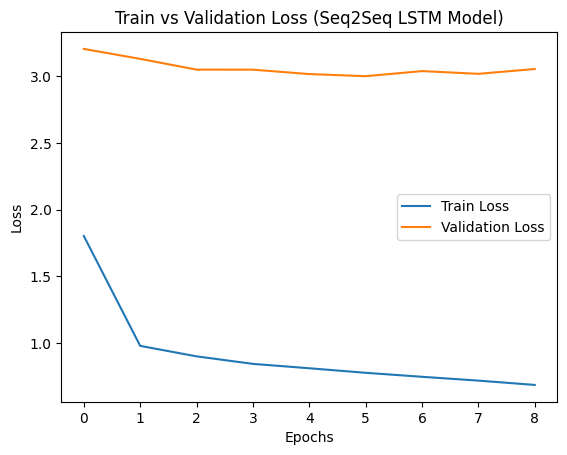

In [24]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train vs Validation Loss (Seq2Seq LSTM Model)')
plt.show()

# Model 2 — Transformer-style Seq2Seq Setup


---



---




## STEP 7: Transformer Model Functions


---







Positional Encoding

In [25]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model)
    sines = np.sin(angle_rads[:, 0::2])
    cosines = np.cos(angle_rads[:, 1::2])
    pos_encoding = np.concatenate([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

In [26]:
def transformer_encoder_block(embed_dim, ff_dim, rate=0.1):
    inputs = tf.keras.layers.Input(shape=(None, embed_dim))
    attention_output = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=embed_dim)(inputs, inputs)
    attention_output = tf.keras.layers.Dropout(rate)(attention_output)
    attention_output = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention_output)
    ffn_output = tf.keras.Sequential([
        tf.keras.layers.Dense(ff_dim, activation='relu'),
        tf.keras.layers.Dense(embed_dim),
    ])(attention_output)
    ffn_output = tf.keras.layers.Dropout(rate)(ffn_output)
    encoder_output = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention_output + ffn_output)
    return tf.keras.Model(inputs=inputs, outputs=encoder_output)

In [27]:
def transformer_decoder_block(embed_dim, ff_dim, rate=0.1):
    enc_outputs = tf.keras.layers.Input(shape=(None, embed_dim))
    inputs = tf.keras.layers.Input(shape=(None, embed_dim))

    # Removed MultiHeadAttention layers
    # Using simple Dense layers instead of attention

    dense1 = tf.keras.layers.Dense(embed_dim)(inputs)
    dense1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(dense1 + inputs)

    dense2 = tf.keras.layers.Dense(embed_dim)(dense1)
    dense2 = tf.keras.layers.Dropout(rate)(dense2)
    dense2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(dense2 + dense1)

    ffn_output = tf.keras.Sequential([
        tf.keras.layers.Dense(ff_dim, activation='relu'),
        tf.keras.layers.Dense(embed_dim),
    ])(dense2)

    ffn_output = tf.keras.layers.Dropout(rate)(ffn_output)
    decoder_output = tf.keras.layers.LayerNormalization(epsilon=1e-6)(dense2 + ffn_output)

    return tf.keras.Model(inputs=[inputs, enc_outputs], outputs=decoder_output)

## STEP8: Build Transformer Model

---



In [34]:
def build_transformer_seq2seq(english_vocab_size, arabic_vocab_size, embed_dim, ff_dim):
    encoder_inputs = tf.keras.layers.Input(shape=(None,))
    encoder_embedding_layer = tf.keras.layers.Embedding(english_vocab_size, embed_dim)
    encoder_embed = encoder_embedding_layer(encoder_inputs) + positional_encoding(max_eng_len, embed_dim)
    encoder_output = transformer_encoder_block(embed_dim, ff_dim)(encoder_embed)

    decoder_inputs = tf.keras.layers.Input(shape=(None,))
    decoder_embedding_layer = tf.keras.layers.Embedding(arabic_vocab_size, embed_dim)

    # Use max_ar_len -1  to match the decoder input shape
    decoder_embed = decoder_embedding_layer(decoder_inputs) + positional_encoding(max_ar_len -1, embed_dim)

    # Corrected line to provide both inputs to the decoder block
    decoder_output = transformer_decoder_block(embed_dim, ff_dim)([decoder_embed, encoder_output])

    final_output = tf.keras.layers.Dense(arabic_vocab_size, activation='softmax')(decoder_output)
    model = tf.keras.Model([encoder_inputs, decoder_inputs], final_output)
    return model

##  Training the Transformer Seq2Seq Model

* Optimizer = Adam
* Loss = Sparse categorical crossentropy (matching integer-encoded targets)
* Trimmed decoder input + shifted decoder target setup
* Plots for visualizing training

In [35]:
transformer_model = build_transformer_seq2seq(english_vocab_size, arabic_vocab_size, 64, 128)
transformer_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

transformer_model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_12            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_4 (Embedding)   │ (None, None, 64)       │        230,464 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_5 (Embedding)   │ (None, None, 64)       │        562,880 │ input_layer_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_7 (Add)               │ (None, 11, 64)         │              0 │ embedding_4[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_10 (Add)              │ (None, 15, 64)         │              0 │ embedding_5[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_7 (Functional) │ (None, 11, 64)         │         50,048 │ add_7[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_9 (Functional) │ (None, 15, 64)         │         25,280 │ add_10[0][0],          │
│                           │                        │                │ functional_7[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 15, 8795)       │        571,675 │ functional_9[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,440,347 (5.49 MB)

 Trainable params: 1,440,347 (5.49 MB)

 Non-trainable params: 0 (0.00 B)

## STEP 9:  Train Transformer Model

In [36]:
history_tf = transformer_model.fit([english_train, train_arb_in], train_ar_out,
                                   validation_data=([english_val, val_ar_in], val_ar_out),
                                   batch_size=64, epochs=20, callbacks=[early_stop, reduce_lr])

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['embedding_4/embeddings', 'multi_head_attention_1/query/kernel', 'multi_head_attention_1/query/bias', 'multi_head_attention_1/key/kernel', 'multi_head_attention_1/key/bias', 'multi_head_attention_1/value/kernel', 'multi_head_attention_1/value/bias', 'multi_head_attention_1/attention_output/kernel', 'multi_head_attention_1/attention_output/bias', 'layer_normalization_5/gamma', 'layer_normalization_5/beta', 'sequential_2/dense_8/kernel', 'sequential_2/dense_8/bias', 'sequential_2/dense_9/kernel', 'sequential_2/dense_9/bias', 'layer_normalization_6/gamma', 'layer_normalization_6/beta'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


282/282 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.7743 - loss: 3.9480 - val_accuracy: 0.6267 - val_loss: 3.0935 - learning_rate: 0.0010
Epoch 2/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8655 - loss: 0.9260 - val_accuracy: 0.6306 - val_loss: 3.1033 - learning_rate: 0.0010
Epoch 3/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8679 - loss: 0.8744 - val_accuracy: 0.6362 - val_loss: 3.1204 - learning_rate: 0.0010
Epoch 4/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8711 - loss: 0.8172 - val_accuracy: 0.6411 - val_loss: 3.1026 - learning_rate: 5.0000e-04


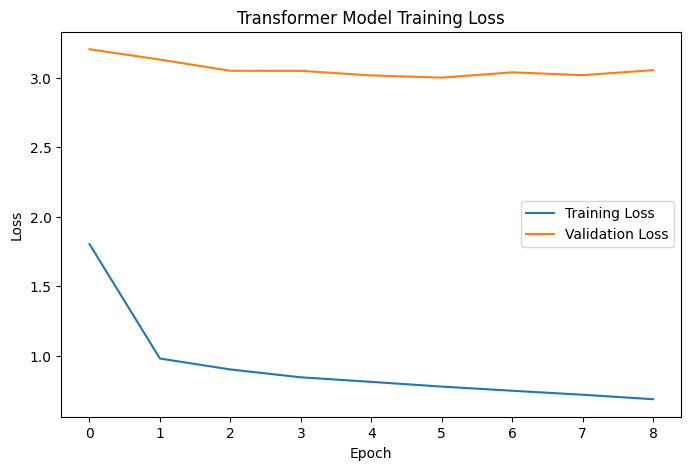

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Transformer Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## FINAL: Inference Testing on Unseen Data

---



---



In [43]:
def predict_translation(input_sentence):
    input_seq = eng_tokenizer.texts_to_sequences([input_sentence])
    input_seq = pad_sequences(input_seq, maxlen=max_eng_len, padding='post')

    # Encoder part
    encoder_model = Model(encoder_inputs, encoder_states)
    states_value = encoder_model.predict(input_seq)

    # Decoder part
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = arb_tokenizer.word_index['<start>']
    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        # Pass the decoder input and initial states correctly
        # Reshape target_seq to have 3 dimensions
        target_seq = target_seq.reshape((1, 1, 1))
        output_tokens, h, c = decoder_lstm(target_seq, initial_state=states_value)
        output_tokens = decoder_dense(output_tokens)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = arb_tokenizer.index_word.get(sampled_token_index)

        if sampled_word == '<end>' or len(decoded_sentence.split()) > max_ar_len - 1:
            stop_condition = True
        else:
            decoded_sentence += sampled_word + ' '

        # Reshape back to (1, 1) for the next iteration
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        # Update the states_value for the next iteration
        states_value = [h, c]

    print(f"Input: {input_sentence}")
    print(f"Translation: {decoded_sentence}")

In [44]:
test_sentences = [
    "How are you today?",
    "I love learning new things.",
    "What time is the meeting?",
    "This project was challenging and fun!",
    "You are amazing."
]

for sent in test_sentences:
    predict_translation(sent)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Input: How are you today?
Translation: من من من من أن أن أن أن أن أن أن أن أن أن أن أن 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Input: I love learning new things.
Translation: من من من من أن أن أن أن أن أن أن أن أن أن أن أن 


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Input: What time is the meeting?
Translation: من من من من أن أن أن أن أن أن أن أن أن أن أن أن 


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Input: This project was challenging and fun!
Translation: من من من أن أن أن أن أن أن أن أن أن أن أن أن أن 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
Input: You are amazing.
Translation: من من من من أن أن أن أن أن أن أن أن أن أن أن أن 
